### 1.0 Setup:

At the beginning of every Python script, necessary packages should be downloaded, installed, and imported. 

In [ ]:
# import Python packages
%matplotlib inline  
import pandas as pd 
import numpy as np  
import scipy as sp 
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size

### 2.0 Data & Data Cleaning:
Free COVID-19 data for Norway can for example be obtained from [covid19data.no](https://www.covid19data.no/index.html "COVID Norway"). The website offers different data, e.g., healthcare data, data on mobility, data on business compensations and unemployment benefits. 

I downloaded data on infections, data on mobility based on APPLE mobility trends, as well as data on COVID-19 testing. Let's suppose that we are interested in finding out whether changing our behaviour by e.g. walking or taking the car instead of public transport can reduce the number of infections. Thus we are interested in estimating the model:

$$ infections_t = \alpha + \beta_1 \cdot walking_t + \beta_2 \cdot transit_t + \beta_3 \cdot driving_t + \varepsilon_t$$


In other words, we regress infections data on the mobility trends data. 

Let's first read-in the data:

In [ ]:
# read in the four data sets
col_names=['date','date_time','kommune_no','kommune_name','fylke_no',
           'fylke_name','population','cases']
url='https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Tutorials/Tutorial__1/municipality.csv'
infections = pd.read_csv(url, delimiter=',',names=col_names,header=1)

col_names = ['geo_type','region','transportation_type','alternative_name',
             'sub-region','country','date','val']
url='https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Tutorials/Tutorial__1/mobilityAPPL.csv'
mobilityAPPL = pd.read_csv(url, delimiter=',',names=col_names,header=1)

url = 'https://raw.githubusercontent.com/BI-DS/EBA-3530/main/Tutorials/Tutorial__1/national_tests.csv'
col_names = ['date','n_tests','n_tests_cumulative']
testing = pd.read_csv(url, delimiter=',',names=col_names,header=1)

# convert the date column to datetime format
mobilityAPPL['date'] = mobilityAPPL['date'].astype('datetime64[ns]')
infections['date'] = infections['date'].astype('datetime64[ns]')
testing['date'] = testing['date'].astype('datetime64[ns]')

Let's have a quick look at the data

In [ ]:
# set the date column as the index variable
infections = infections.set_index('date')
mobilityAPPL = mobilityAPPL.set_index('date')
testing = testing.set_index('date')

# sort the testing data in ascending order (it is the other way round in the raw data)
testing = testing.sort_values(by='date', ascending=True)

# A useful method to get a quick look at a data frame
infections.head() 

,date_time,kommune_no,kommune_name,fylke_no,fylke_name,population,cases
date,,,,,,,
2020-03-26,2020-03-26T04:00:00Z,1101,Eigersund,11,Rogaland,14811,6
2020-03-26,2020-03-26T04:00:00Z,1103,Stavanger,11,Rogaland,143574,87
2020-03-26,2020-03-26T04:00:00Z,1106,Haugesund,11,Rogaland,37357,41
2020-03-26,2020-03-26T04:00:00Z,1108,Sandnes,11,Rogaland,79537,34
2020-03-26,2020-03-26T04:00:00Z,1111,Sokndal,11,Rogaland,3280,2


After a quick look at the other dataframes (omitted here) we realise that the datasets are not aligned. We hence need to adjust the samples. Moreover, since the testing data is only available at national level, we have to aggregate the data across municipalities. We hence have to sum up all the cases that were recorded in different municipalities for every day. Moreover, to get rid of nonlinear trends in the data we will also take log-differences of the individual series (the logarithm "linearises" non-linear trends. Differencing then simply substracts these from the data). Note that you will learn about stationarity of time-series data in a later lecture. 

In [ ]:
# Allign the sample length
infections = infections['2020-04-01':'2020-12-22']
mobilityAPPL = mobilityAPPL['2020-04-01':'2020-12-22']
testing = testing['2020-04-01':'2020-12-22']

# aggregate the daily infections data across municipalities. Parsing the argument as a list "[['cases']]" 
# automatically results in a new pd.DataFrame. Here we simply sum up the cases for every day.
infections = infections.groupby('date')[['cases']].sum()

# take log-differences of the cases
infections['ld_cases'] = np.log(infections.cases) - np.log(infections.cases.shift(1))

# take log-differences of the testing data. Since there is days with zero tests conducted,
# we add a small epsilon to avoid taking logs of 0! 
testing['ld_ntests'] = np.log(testing.n_tests + 10**-13 ) - np.log(testing.n_tests.shift(1) + 10**-13)

# mobility APPL already provides aggregated data. 
mobilityAPPL = mobilityAPPL[mobilityAPPL['region']=='Norway']

# extract the mobility trends by type and rename the value column. Take log-differences
driving = mobilityAPPL.loc[mobilityAPPL['transportation_type'] == 'driving', ['val']]
driving.rename(columns = {'val':'ld_driving'}, inplace = True)
driving.ld_driving =  np.log(driving.ld_driving) - np.log(driving.ld_driving.shift(1))

transit = mobilityAPPL.loc[mobilityAPPL['transportation_type'] == 'transit', ['val']]
transit.rename(columns = {'val':'ld_transit'}, inplace = True)
transit.ld_transit = np.log(transit.ld_transit) - np.log(transit.ld_transit.shift(1))

walking = mobilityAPPL.loc[mobilityAPPL['transportation_type'] == 'walking', ['val']]
walking.rename(columns = {'val':'ld_walking'}, inplace = True)
walking.ld_walking = np.log(walking.ld_walking) - np.log(walking.ld_walking.shift(1))

Let's collect the data into one dataframe. In order to do so, we use panda's "merge" function, where we merge using the date column. Once the merging is completed, we can drop all rows that contain missing values in one of the variables. Also let's add 10 lags of the dependent variable, which corresponds to the length of quarantine in Norway. The idea is that after 10 days patients that are infected will usually have developed symptoms and hence got tested. Hence, if more people are infected now, this should have a positive effect on infections over the next 10 days. 

In [ ]:
# define the list of dataframes to be merged
dfs = [infections, driving, transit, walking, testing[['ld_ntests']]] 

# merge the datasets specified in 'dfs'. Here we use and one-line lambda function
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'], how='outer'), dfs)

# drop rows that contain missing values
df_merged = df_merged.dropna()

# add a lagged dependent variables
df_merged['ld_cases_1'] = df_merged.ld_cases.shift(1)
df_merged['ld_cases_2'] = df_merged.ld_cases.shift(2)
df_merged['ld_cases_3'] = df_merged.ld_cases.shift(3)
df_merged['ld_cases_4'] = df_merged.ld_cases.shift(4)
df_merged['ld_cases_5'] = df_merged.ld_cases.shift(5)
df_merged['ld_cases_6'] = df_merged.ld_cases.shift(6)
df_merged['ld_cases_7'] = df_merged.ld_cases.shift(7)
df_merged['ld_cases_8'] = df_merged.ld_cases.shift(8)
df_merged['ld_cases_9'] = df_merged.ld_cases.shift(9)
df_merged['ld_cases_10'] = df_merged.ld_cases.shift(10)

df_merged = df_merged.dropna()
df_merged = df_merged[['ld_cases', 'ld_cases_1', 'ld_cases_2', 'ld_cases_3'
                       , 'ld_cases_4', 'ld_cases_5', 'ld_cases_6', 'ld_cases_7'
                       , 'ld_cases_8', 'ld_cases_9', 'ld_cases_10',
                       'ld_driving', 'ld_transit', 'ld_walking', 'ld_ntests']]

We have now successfully extracted the data we need and completed some initial data cleaning. 

In [ ]:
df_merged.head()

,ld_cases,ld_cases_1,ld_cases_2,ld_cases_3,ld_cases_4,ld_cases_5,ld_cases_6,ld_cases_7,ld_cases_8,ld_cases_9,ld_cases_10,ld_driving,ld_transit,ld_walking,ld_ntests
date,,,,,,,,,,,,,,,
2020-04-16,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,0.057830,0.058005,0.009646,-0.089199,-0.022700,0.751233
2020-04-17,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,0.057830,0.068837,0.052594,0.075716,-0.322364
2020-04-18,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.021873,-0.030563,-0.034201,0.049472,0.305319
2020-04-19,0.011968,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.018077,0.022257,0.093911,0.008343,-0.317653
2020-04-20,0.006353,0.011968,0.013419,0.014338,0.016642,0.016619,0.011954,0.011319,0.014924,0.012262,0.024335,0.051259,0.031809,0.036527,-0.830231


Let's now have a brief look at the time series. In this context, plotting and eye-balling the data is always a good first step.

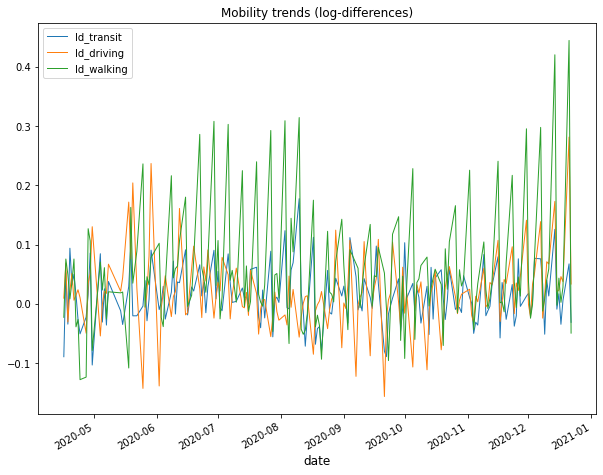

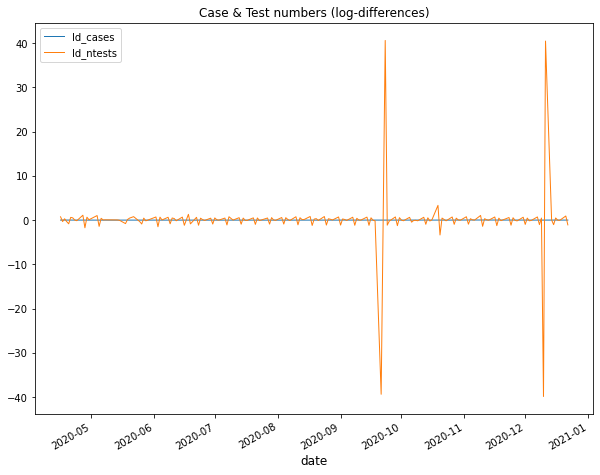

In [ ]:
ax = df_merged[['ld_transit','ld_driving','ld_walking']].plot(lw=1)
ax.set_xlabel('date', fontsize=12)
plt.title("Mobility trends (log-differences)")
plt.show()

ax2 = df_merged[['ld_cases','ld_ntests']].plot(lw=1)
ax2.set_xlabel('date', fontsize=12)
plt.title("Case & Test numbers (log-differences)")
plt.show()

We immediately notice that the data seems to follow a strong seasonal pattern:

* Testing might not be conducted on weekends 
* infections data might only be updated on weekdays
* Compared to weekends, during the week people have to commute to work
* people might take more walks during summer months compared to winter months
* ...

For this reason, we will also add weekday dummies and monthly/seasonal dummies to the regression. 

In [ ]:
# ---------------------------------------------------create weekday dummies-------------------------------------------------------------

# specify weekdays 
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# extract weekdays from dates
df_merged['Weekday'] = df_merged.index.weekday

# use pandas "get_dummies" to convert the weekday column into binary indicators/dummies that we join to the dataset
df_merged = df_merged.join(pd.get_dummies(df_merged.Weekday))

# apply the names to the newly created columns
column_indices = list(range(16,23,1))
old_names = df_merged.columns[column_indices]
df_merged.rename(columns=dict(zip(old_names, names)), inplace=True)

# drop the weekday column
df_merged = df_merged.drop(['Weekday'], axis=1)

# ---------------------------------------------------create monthly dummies-------------------------------------------------------------

# specify months (we know that our data starts in April)
names = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_merged['month'] = df_merged.index.month

# use pandas "get_dummies" to convert the month column into binary indicators/dummies that we join to the dataset
df_merged = df_merged.join(pd.get_dummies(df_merged.month))

# apply the names to the newly created columns
column_indices = list(range(23,32,1))
old_names = df_merged.columns[column_indices]
df_merged.rename(columns=dict(zip(old_names, names)), inplace=True)

# drop the month column. Also drop one dummy each due to multicoliniarity
df_merged = df_merged.drop(['month','Monday','Apr'], axis=1)


print(list(df_merged))

['ld_cases', 'ld_cases_1', 'ld_cases_2', 'ld_cases_3', 'ld_cases_4', 'ld_cases_5', 'ld_cases_6', 'ld_cases_7', 'ld_cases_8', 'ld_cases_9', 'ld_cases_10', 'ld_driving', 'ld_transit', 'ld_walking', 'ld_ntests', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


 ### 3.0 OLS regressions
 
 #### 3.1 Model
 
 
After having compiled our data set, we are now ready to run a regression. As is specified above, we regress the infections data on our mobility trends data, an intercept, as well as the testing data and our dummies. Instead of the equation that we proposed originally, we will estimate the model:

$$ \Delta ln(infections_t) = \alpha + \beta_1 \cdot \Delta ln(walking_t) + \beta_2 \cdot \Delta ln(transit_t) + \beta_3 \cdot \Delta ln(driving_t) + \sum_{i=4}^k\beta_i \cdot C_{i,t} + \varepsilon_t$$

### 3.2 Implementation with `statsmodels`

In [ ]:
# convert the cases to a numpy array
Y = df_merged.ld_cases.to_numpy()

# convert numpy ndarray to array
Y = np.asarray(Y)
Y = Y.T

# convert the rest of 
column_indices = list(range(1,29,1))
X = df_merged[df_merged.columns[column_indices]].to_numpy()
X = np.asarray(X)

# add the intercept to the RHS/independent variables
X = np.concatenate((np.ones([X.shape[0],1]), X), axis=1)

# obtain lables for row names in output table
varnames = np.asarray(df_merged.columns[column_indices])
varnames = np.concatenate([['intercept'],varnames])

# run the regression
model = sm.OLS(Y, X)
results = model.fit()

# print output table
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     45.95
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           3.06e-58
Time:                        12:31:49   Log-Likelihood:                 813.93
No. Observations:                 173   AIC:                            -1570.
Df Residuals:                     144   BIC:                            -1478.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.253      0.212      -0.005       0.001
x1             0.4454      0.084      5.323      0.000       0.280       0.611
x2             0.2731      0.093      2.923      0.004       0.088       0.458
x3             0.1499      0.093      1.615      0.108      -0.034       0.333
x4            -0.1241      0.091     -1.364      0.175      -0.304       0.056
x5             0.3205      0.087      3.684      0.000       0.149       0.493
x6            -0.1411      0.086     -1.634      0.104      -0.312       0.030
x7            -0.0779      0.084     -0.929      0.355      -0.244       0.088
x8            -0.0849      0.084     -1.014      0.312      -0.250       0.081
x9             0.0560      0.068      0.830      0.408      -0.077       0.189
x10           -0.0054      0.052     -0.105      0.917      -0.108       0.097
x11           -0.0069      0.004     -1.782      0.077      -0.015       0.001
x12            0.0043      0.005      0.817      0.415      -0.006       0.015
x13            0.0040      0.003      1.262      0.209      -0.002       0.010
x14         6.169e-05   3.06e-05      2.014      0.046    1.15e-06       0.000
x15            0.0044      0.001      5.074      0.000       0.003       0.006
x16            0.0046      0.001      4.729      0.000       0.003       0.007
x17            0.0045      0.001      4.650      0.000       0.003       0.006
x18            0.0038      0.001      4.043      0.000       0.002       0.006
x19            0.0039      0.003      1.430      0.155      -0.001       0.009
x20            0.0022      0.003      0.791      0.430      -0.003       0.008
x21           -0.0010      0.001     -0.750      0.455      -0.003       0.002
x22           -0.0013      0.001     -0.884      0.378      -0.004       0.002
x23           -0.0014      0.002     -0.903      0.368      -0.004       0.002
x24           -0.0007      0.001     -0.496      0.621      -0.003       0.002
x25            0.0003      0.001      0.285      0.776      -0.002       0.002
x26            0.0014      0.001      1.323      0.188      -0.001       0.003
x27            0.0018      0.001      1.168      0.245      -0.001       0.005
x28            0.0005      0.001      0.476      0.635      -0.002       0.003
==============================================================================
Omnibus:                       50.981   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.236
Skew:                           1.074   Prob(JB):                     1.09e-42
Kurtosis:                       7.711   Cond. No.                     4.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

### 4.0 Interpretation

In [ ]:
print('log-approximation:')
print((np.log(12)-np.log(11))*100)
print()
print('actual % change:')
print(((12-11)/11)*100)

log-approximation:
8.701137698962969

actual % change:
9.090909090909092


Thus recall that in standard log-log regressions we interpret "A $1$% increase in $X$, leads to a $\beta$% increase in $Y$". We can now use a simple trick:

For 

$$ ln(Y_t) = \alpha + \beta\cdot ln(X_t) $$

we have

$$ ln(Y_t) - ln(Y_{t-1})= \alpha + \beta\cdot ln(X_t) - \alpha - \beta\cdot ln(X_{t-1}) $$

or 

$$ \Delta ln(Y_t)= \beta\cdot \Delta ln(X_t) $$

Notice that this is exactly the same $\beta$! We can hence stick to the general interpretation.

Let's look at "driving" as an example. A 1% increase in APPLE maps request for driving directions, leads to a -0.0069% change in infections, and it is significant at the 10% level. An increase in APPLE maps requests for public transport and walking on the other hand, seems to have a positive effect on infections. Neither effect is statistically significant, however. 
